## Generate/Load data

In [1]:
# import deeptrack as dt 
# from numpy.random import uniform
# import numpy as np
# from matplotlib import pyplot as plt
# from torch.utils.data import ConcatDataset
# import torch

# # Train dataset

# image_size = 32

# particle_C = dt.Ellipse(
#             intensity = 5.0,
#             position_unit="pixel",
#             position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
#             radius=(5, 5)*dt.units.pixel,
#         )

# optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size), NA=2)

# simulation_C = (
#     optics(particle_C) 
#     >> dt.NormalizeMinMax(0, 1)
#     >> dt.Gaussian(sigma=0.1)
#     >> dt.MoveAxis(-1, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float32)
# )

# # Circle
# train_dataset_C = dt.pytorch.Dataset(simulation_C & [0], length=100)

# plt.figure(figsize=(10, 2))
# for i in range(5):
# 	image  = train_dataset_C[int(i)]
# 	plt.subplot(1, 5, i+1)
# 	plt.imshow(image[0].squeeze(), cmap="gray", origin="lower")
# plt.tight_layout()
# plt.show()

# # Test dataset

# test_image_size = 96
# test_optics = dt.Fluorescence(output_region=(0, 0, test_image_size, test_image_size), NA=2)

# test_particle_C = dt.Ellipse(
#             intensity = 5.0,
#             position_unit="pixel",
#             position=lambda: uniform(test_image_size / 2 - 30, test_image_size / 2 + 30, size=2),
#             radius=(5, 5)*dt.units.pixel,
#         )

# test_simulation_C = (
#     test_optics(test_particle_C)
#     >> dt.NormalizeMinMax(0, 1)
#     >> dt.Gaussian(sigma=0.1)
#     >> dt.MoveAxis(-1, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float32)
# )

# test_simulation_C_gt = (
#     test_optics(test_particle_C)
#     >> dt.NormalizeMinMax(0, 1)
#     >> dt.MoveAxis(-1, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float32)
# )

# # Circle
# test_dataset_C = dt.pytorch.Dataset(test_simulation_C & test_simulation_C_gt & test_particle_C.position, length=100)

# plt.figure(figsize=(10, 2))
# for i in range(5):
# 	image, *_  = test_dataset_C[int(i)]
# 	plt.subplot(1, 5, i+1)
# 	plt.imshow(image[0], cmap="gray", origin="lower")
# plt.tight_layout()
# plt.show()

# # Dataset C
# train_dataset_list = [(img, label) for img, label in train_dataset_C]
# test_dataset_list = [(img, sim1, pos1) for img, sim1, pos1 in test_dataset_C]

# combined_dataset = {
#     'train': train_dataset_list,
#     'test': test_dataset_list
# }

# torch.save(combined_dataset, 'dataset_C.pt')

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Load circle
dataset = torch.load('dataset_C.pt')
test_dataset_C = dataset['test']
train_dataset_C = dataset['train']
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)
train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)

## Load model

In [90]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        self.losses = {
            'between_image_disagreement': [],
            'within_image_disagreement': [],
            'mask_loss': []
        }

        super().__init__(loss=self.compute_loss, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (self.num_classes + 1),
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        out = self.model(x)
        classes=out[:, :, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        
        if self.training:
            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None] #torch.ones_like(y[:, 2:3, ...])
        
        return torch.cat(
            [mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(-2, -1), keepdim=True)

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms
        mask_gumbel, classes = y_hat[:, 0:1], y_hat[:, 1:]
        
        # Normalize mask
        mask_gumbel = self.normalize(mask_gumbel)
        
        # Calculate weighted spatial average for each class (reduce)
        weighted_classes = classes * mask_gumbel
        classes_reduced = weighted_classes.sum(dim=(2, 3)) / mask_gumbel.sum(dim=(2, 3))
        # Expand back to original spatial dimensions
        classes_reduced = classes_reduced[..., None, None].expand_as(classes)

        # Calculate within-image disagreement
        within_disagreement = (classes - classes_reduced) * mask_gumbel
        within_disagreement_loss = F.mse_loss(
            within_disagreement, 
            torch.zeros_like(within_disagreement)
        )
        
        # Calculate between-image consistency using Binary Cross-Entropy
        between_disagreement_loss = 0
        for i in range(0, classes.size(0), self.n_transforms):
            batch_classes = classes[i:i + self.n_transforms]
            batch_mean = batch_classes.mean(dim=0, keepdim=True).expand_as(batch_classes)
            epsilon = 1e-7 # Add small epsilon to avoid numerical instability
            between_disagreement_loss = F.binary_cross_entropy(
                batch_classes.clamp(epsilon, 1 - epsilon),
                batch_mean.detach().clamp(epsilon, 1 - epsilon),  # Detach to prevent duplicate gradients
                reduction='mean'
            ) / B
        
        # Apply weights
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss
        }

    def on_train_end(self) -> None:
        self.eval()
        self.plot_losses()
        return super().on_train_end()

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

## Train

In [91]:
import deeplay as dl

lodestar2_C = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
trainer_lodestar_C = dl.Trainer(max_epochs=40, accelerator='cpu')
trainer_lodestar_C.fit(lodestar2_C, train_dataloader_C)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  250 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 250 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 250 K                                                                                                
Total estimated model params size (MB): 1

Output()

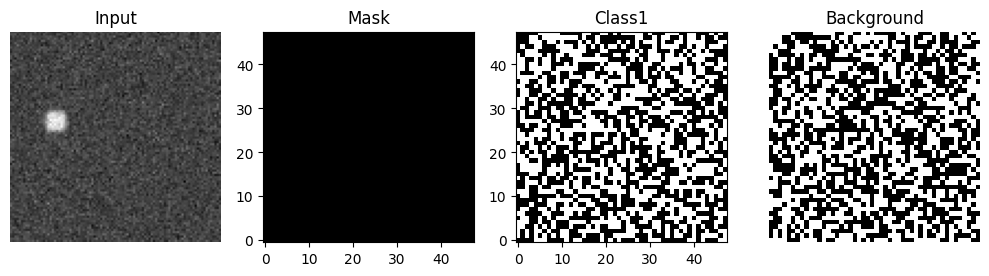

In [92]:
data, *_ = next(iter(test_dataloader_C))
output = lodestar2_C((data)).detach()
import matplotlib.pyplot as plt

x = 5

plt.figure(figsize=(10, 6))
for i in range(4):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
		plt.axis('off')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Class1')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Background')
		
plt.tight_layout()
plt.axis('off')
plt.show()

In [93]:
# from typing import Callable, Optional

# import numpy as np
# import scipy
# import scipy.ndimage
# import torch
# import torch.nn as nn
# from skimage import morphology

# from deeplay import ConvolutionalNeuralNetwork, Application

# from deeplay.applications.detection.lodestar.transforms import (
#     RandomRotation2d,
#     RandomTranslation2d,
#     Transforms,
# )

# import torch.nn.functional as F

# class LodeSTAR(Application):

#     # num_outputs: int # only 2D for now
#     num_classes: int
#     transforms: Transforms
#     n_transforms: int
#     model: nn.Module
#     between_loss: Callable
#     within_loss: Callable
#     between_loss_weight: float
#     within_loss_weight: float

#     def __init__(
#         self,
#         model: Optional[nn.Module] = None,
#         num_classes: int = 2,
#         transforms: Optional[Transforms] = None,
#         n_transforms: int = 2,
#         between_loss: Optional[Callable] = None,
#         within_loss: Optional[Callable] = None,
#         between_loss_weight: float = 1,
#         within_loss_weight: float = 10,
#         **kwargs
#     ):
#         if transforms is None:
#             transforms = Transforms(
#                 [
#                     RandomTranslation2d(),
#                     RandomRotation2d(),
#                 ]
#             )

#         self.num_classes = num_classes
#         self.transforms = transforms
#         self.n_transforms = n_transforms
#         self.model = model or self._get_default_model()
#         self.between_loss = between_loss or nn.L1Loss(reduction="mean")
#         self.within_loss = within_loss or nn.L1Loss(reduction="mean")
#         self.between_loss_weight = between_loss_weight
#         self.within_loss_weight = within_loss_weight

#         self.losses = {
#             'between_image_disagreement': [],
#             'within_image_disagreement': [],
#             'mask_loss': []
#         }

#         super().__init__(loss=self.compute_loss, **kwargs)

#     def _get_default_model(self):
#         cnn = ConvolutionalNeuralNetwork(
#             None,
#             [32, 32, 64, 64, 64, 64, 64, 64, 64],
#             (2 + 1) + (self.num_classes + 1),
#         )
#         cnn.blocks[2].pooled()

#         return cnn

#     def transform_data(self, batch):
#         repeated = batch.repeat_interleave(self.n_transforms, dim=0)
#         transformed, inverse = self.transforms(repeated)
#         return transformed, inverse

#     def forward(self, x):

#         if self.training:
#             x, class_label = x

#         out = self.model(x)
#         y = out[:, :3, ...]
#         classes=out[:, 3:, ...]
#         classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

#         batch_size = classes.size(0)
#         num_channels = classes.size(1)
#         _, _, Hx, Wx = x.shape
#         _, _, Hy, Wy = y.shape
#         x_range = torch.arange(Hy, device=x.device) * Hx / Hy
#         y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
#         if self.training:
#             x_range = x_range - Hx / 2 + 0.5
#             y_range = y_range - Wx / 2 + 0.5

#             batch_indices = torch.arange(batch_size)

#             mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
#         else:
            
#             mask = classes.sum(dim=1)[:,None] #torch.ones_like(y[:, 2:3, ...])


#         Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

#         delta_x = y[:, 0:1, ...]
#         delta_y = y[:, 1:2, ...]
#         yy = y[:, 2:3, ...]
#         weights = y[:, 2:3, ...].sigmoid()
#         X = X + delta_x
#         Y = Y + delta_y
        
#         return torch.cat(
#             [X, Y, weights, mask, classes], dim=1
#         )

#     def normalize(self, weights):
#         weights = weights + 1e-5
#         return weights / weights.sum(dim=(2, 3), keepdim=True)

#     def reduce(self, X, weights):
#         return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

#     def compute_loss(self, y_hat, inverse_fn):
#         B = y_hat.size(0) / self.n_transforms

#         y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]
        
#         mask_gumbel = self.normalize(mask_gumbel)
#         y_reduced = self.reduce(y_pred, mask_gumbel)

#         within_disagreement = (y_pred - y_reduced[..., None, None]) * mask_gumbel 
#         within_disagreement_loss = self.within_loss(
#             within_disagreement, torch.zeros_like(within_disagreement)
#         )

#         y_reduced_on_initial = inverse_fn(y_reduced)

#         between_disagreement_loss = 0

#         for i in range(0, y_pred.size(0), self.n_transforms):
#             batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
#             batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
#                 batch_preds
#             )
#             between_disagreement_loss += (
#                 self.between_loss(batch_preds, batch_mean_pred) / B
#             )
#         weighted_between_loss = between_disagreement_loss * self.between_loss_weight
#         weighted_within_loss = within_disagreement_loss * self.within_loss_weight

#         self.save_losses({
#             'between_image_disagreement': weighted_between_loss.item(),
#             'within_image_disagreement': weighted_within_loss.item()
#         })

#         return {
#             "between_image_disagreement": weighted_between_loss,
#             "within_image_disagreement": weighted_within_loss
#         }

#     def save_losses(self, current_losses):
#         for key, value in current_losses.items():
#             self.losses[key].append(value)

#     def get_losses(self):
#         return self.losses

#     def plot_losses(self):
#         import matplotlib.pyplot as plt

#         fig, axs = plt.subplots(2, 2, figsize=(15, 10))
#         fig.suptitle('Training Losses')
#         for ax, (key, values) in zip(axs.ravel(), self.losses.items()):
#             ax.plot(values)
#             ax.set_title(key)
#             ax.set_xlabel('Iterations')
#             ax.set_ylabel('Loss')
#         plt.tight_layout()
#         plt.show()

#     def on_train_end(self) -> None:
#         self.eval()
#         self.plot_losses()
#         return super().on_train_end()

#     def pooled(self, x, mask=1):
#         """Pooled output from model.

#         Predict and pool the output from the model. Useful to acquire a single output from the model.
#         Masking is supported by setting the mask to 0 where the output should be ignored.

#         Parameters
#         ----------
#         x : array-like
#             Input to model
#         mask : array-like
#             Mask for pooling. Should be the same shape as the output from the model with a single channel.
#         """
#         y = self(x.to(self.device))
#         y_pred, weights,  = y[:, :2], y[:, 2:3]
#         masked_weights = weights * mask

#         pooled = self.reduce(y_pred, self.normalize(masked_weights))

#         return pooled

#     def train_preprocess(self, batch):
#         batch, class_label = batch
#         x, inverse = self.transform_data(batch)
#         class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
#         return (x, class_label), inverse

#     def val_preprocess(self, batch):
#         batch,_,_ = batch
#         x, inverse = self.transform_data(batch)
#         return (x,), inverse

#     test_preprocess = val_preprocess

#     def on_train_end(self) -> None:
#         self.eval()
#         return super().on_train_end()

In [94]:
    # def compute_loss(self, y_hat, inverse_fn):
    #     B = y_hat.size(0) / self.n_transforms

    #     mask_gumbel, classes = y_hat[:, 0:1], y_hat[:, 1:]
        
    #     mask_gumbel = self.normalize(mask_gumbel)

    #     between_disagreement_loss = 0
    #     for i in range(0, classes.size(0), self.n_transforms):
    #         # Get predictions for the same image under different transforms
    #         batch_classes = classes[i:i + self.n_transforms]
            
    #         # Calculate mean prediction across transformations
    #         batch_mean_classes = batch_classes.mean(dim=0, keepdim=True).expand_as(batch_classes)
            
    #         # Calculate disagreement between transformations
    #         between_disagreement_loss += (
    #             self.between_loss(batch_classes, batch_mean_classes) / B
    #         )
        
    #     # Calculate within-class disagreement for spatial consistency
    #     class_probs = classes.softmax(dim=1)
    #     spatial_mean = F.avg_pool2d(class_probs, 3, stride=1, padding=1)
    #     within_disagreement_loss = self.within_loss(
    #         class_probs, spatial_mean
    #     )
        
    #     # Apply weights
    #     weighted_between_loss = between_disagreement_loss * self.between_loss_weight
    #     weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
    #     return {
    #         "between_image_disagreement": weighted_between_loss,
    #         "within_image_disagreement": weighted_within_loss
    #     }